Import MNIST Dataset

2025-12-06 23:41:14.973033: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 23:41:15.002428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 23:41:15.864726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


---Shape Info---
Training Images shape: (60000, 28, 28)
Training Labels shape: (60000,)
Test Images shape: (10000, 28, 28)
Test Labels shape: (10000,)
---Value Info---
Pixel Value Range : 0 to 255
Example Label : 5


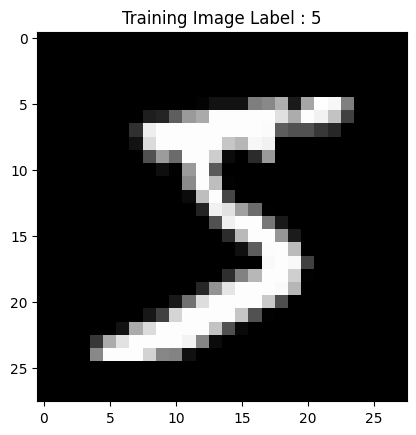

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test) = mnist.load_data()

print("---Shape Info---")
print(f"Training Images shape: {x_train.shape}")
print(f"Training Labels shape: {y_train.shape}")
print(f"Test Images shape: {x_test.shape}")
print(f"Test Labels shape: {y_test.shape}")

print("---Value Info---")
print(f"Pixel Value Range : {x_train.min()} to {x_train.max()}")
print(f"Example Label : {y_train[0]}")

plt.imshow(x_train[0],cmap='grey')
plt.title(f"Training Image Label : {y_train[0]}")
plt.show()

Preparing Dataset for Maths

In [2]:
x_train_formatted = x_train.reshape(x_train.shape[0],-1).T
x_test_formatted = x_test.reshape(x_test.shape[0],-1).T

# prevent exploding maths. shifting range from (0-255) To (0-1)
x_train_formatted=x_train_formatted/255
x_test_formatted=x_test_formatted/255

m = x_test_formatted.shape[1]

print("Data Prepared")
print(f"Training Images shape: {x_train_formatted.shape}")
print(f"Training Labels shape: {y_train.shape}")

Data Prepared
Training Images shape: (784, 60000)
Training Labels shape: (60000,)


1-W&B initialize
2-Maths : Forward Propagation ,ReLU ,SoftMax, One_Hot ,Cost Function, Error Calculation, Back Propagation.

In [3]:
def init_params():
    w1 = np.random.rand(64,784) - 0.5  # shift range from (0-1) to (-0.5 - 0.5). this helps a negative weight to be identified as not a match if pixel is lit, also solves zig-zag problem
    b1 = np.random.rand(64,1) - 0.5
    w2 = np.random.rand(10,64) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return w1,b1,w2,b2
#-----------------------------------------------------------------------
def ReLU(z):
    return np.maximum(z,0)
#-----------------------------------------------------------------------
def Softmax(z):
    expZ = np.exp(z-np.max(z)) # euler's number turns any negative value in Z to small positive value, rest is to keep numerical stability and avoid exploding math in case of large Z values
    return expZ/sum(expZ)
#-----------------------------------------------------------------------
def forward_prop(w1,b1,w2,b2,x):
    z1 = np.dot(w1,x)+b1
    a1 = ReLU(z1)

    z2 = np.dot(w2,a1)+b2
    a2 = Softmax(z2)

    return z1,a1,z2,a2
#------------------------------------------------------------------------
def one_hot(y):  # convert sample label into a vector
    one_hot_y = np.zeros((y.shape[0],10))
    one_hot_y[np.arange(y.shape[0]),y] = 1
    return one_hot_y.T
#-----------------------------------------------------------------------
def derive_ReLU(z):  # element wise multiplication , if a neuron in layer 1 outputted 0 it didn't contribute therefore we can't blame for error
    return z>0
#-----------------------------------------------------------------------
def back_prop(w1,a1,z1,w2,a2,z2,x,y):
    one_hot_y = one_hot(y)

    dz2 = a2 - one_hot_y
    dw2 = 1/m * np.dot(dz2,a1.T)
    db2 = 1/m * np.sum(dz2)

    dz1 = np.dot(w2.T,dz2) * derive_ReLU(z1)
    dw1 = 1/m * np.dot(dz1,x.T)
    db1 = 1/m * np.sum(dz1)

    return dw1,db1,dw2,db2
#-----------------------------------------------------------------------
def update_params(w1,b1,dw1,db1,w2,b2,dw2,db2,alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    return w1,b1,w2,b2


Training

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(W1, A1, Z1, W2, A2, Z2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, dW1, db1, W2, b2, dW2, db2, alpha)

        if i % 50 == 0:
            print(f"Iteration: {i} | Accuracy: {get_accuracy(get_predictions(A2), Y):.2%}")

    return W1, b1, W2, b2

W1, b1, W2, b2 = gradient_descent(x_train_formatted, y_train, 0.10, 2000)

ValueError: operands could not be broadcast together with shapes (64,784) (10,64) 

evaluating

In [ ]:
import matplotlib.pyplot as plt

def visualize_50_samples(W1, b1, W2, b2, X, Y):
    fig, axes = plt.subplots(5, 10, figsize=(20, 12))
    axes = axes.flatten()

    for i in range(50):
        current_image = X[:, i, None]
        actual_label = Y[i]

        _, _, _, A2 = forward_prop(W1, b1, W2, b2, current_image)
        prediction = get_predictions(A2)[0]

        img_display = current_image.reshape((28, 28)) * 255
        axes[i].imshow(img_display, cmap='gray', interpolation='nearest')

        if prediction == actual_label:
            color = 'green'
        else:
            color = 'red'

        axes[i].set_title(f"Pred: {prediction}\nTrue: {actual_label}", color=color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_50_samples(W1, b1, W2, b2, x_test_formatted, y_test)